## Notebook setup

In [204]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import dhelp

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd
import dhelp 
from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [205]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [206]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
#symbol = sys.argv[1]
symbol = "AM"

investor_report_url_dict= dhelp.get_investor_report_url_dict()
morningstar_report_url_dict=dhelp.get_morningstar_report_url_dict()
exchange_dict=dhelp.get_exchange_dict()
similar_companies_dict=dhelp.get_similar_companies_dict()

if (symbol in investor_report_url_dict):
    investor_report_url = investor_report_url_dict[symbol]
else:
    investor_report_url=""

if (symbol in morningstar_report_url_dict):
    morningstar_report_url = morningstar_report_url_dict[symbol]
else:
    morningstar_report_url= ""

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]

if (symbol in exchange_dict):
    exchange=exchange_dict[symbol]
else:
    exchange = "NYSE"

report_name = f"{symbol}".upper()

In [207]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [208]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for GSL with starting period 2021-08-17.

('Investment Research Report on GSL',
 '08 February, 2023',
 '16:12',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [209]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/23,ending 12/31/24
No. of Analysts,3,2,2,4,2
Average Estimate,153 USD,155 USD,156 USD,645 USD,705 USD
Year Ago,154 USD,154 USD,154 USD,-,645 USD
Publish Date,3/7/2023,5/8/2023,8/3/2023,-,-


In [210]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)
df_year_estimates

,2023,2024,2025
YEARLY ESTIMATES,,,
Revenue,645,705,559
Dividend,1.50,1.50,-
Dividend Yield (in %),7.81 %,7.81 %,-
EPS,8.67,11.26,-
P/E Ratio,2.21,1.71,2.38


In [211]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

8 news articles for  Global Ship Lease, Inc. were found since 2023-02-01

In [212]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Morgan Stanley,2.039 M,2022-09-29,5.54 %,40.035 M
2,"Punch & Associates Investment Management, Inc.",1.860 M,2022-09-29,5.05 %,36.516 M
3,Marshall Wace LLP,1.571 M,2022-09-29,4.27 %,30.840 M
4,"Whitefort Capital Management, LP",1.412 M,2022-09-29,3.84 %,27.722 M
5,Goldman Sachs Group Inc,1.411 M,2022-09-29,3.83 %,27.700 M
6,"Nokomis Capital, L.l.c.",1.198 M,2022-09-29,3.25 %,23.527 M
7,"Renaissance Technologies, LLC",575.728 K,2022-09-29,1.56 %,11.304 M
8,Citadel Advisors Llc,535.780 K,2022-09-29,1.46 %,10.520 M
9,"Susquehanna International Group, LLP",501.113 K,2022-09-29,1.36 %,9.839 M
10,No Street GP LP,500 K,2022-09-29,1.36 %,9.818 M


In [213]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,Morgan Stanley,2.039 M,2022-09-29,5.54 %,40.035 M
1,"Punch & Associates Investment Management, Inc.",1.860 M,2022-09-29,5.05 %,36.516 M
2,Marshall Wace LLP,1.571 M,2022-09-29,4.27 %,30.840 M
3,"Whitefort Capital Management, LP",1.412 M,2022-09-29,3.84 %,27.722 M
4,Goldman Sachs Group Inc,1.411 M,2022-09-29,3.83 %,27.700 M
5,"Nokomis Capital, L.l.c.",1.198 M,2022-09-29,3.25 %,23.527 M
6,"Renaissance Technologies, LLC",575.728 K,2022-09-29,1.56 %,11.304 M
7,Citadel Advisors Llc,535.780 K,2022-09-29,1.46 %,10.520 M
8,"Susquehanna International Group, LLP",501.113 K,2022-09-29,1.36 %,9.839 M
9,No Street GP LP,500 K,2022-09-29,1.36 %,9.818 M


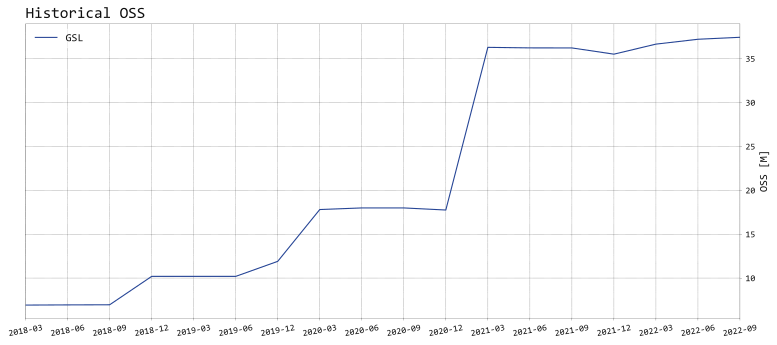

In [214]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric([symbol],"OSS", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
shares_outstanding_chart = f.getvalue().decode("utf-8")

In [215]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Morgan Stanley,2.039 M,2022-09-29,5.54 %,40.035 M
2,"Punch & Associates Investment Management, Inc.",1.860 M,2022-09-29,5.05 %,36.516 M
3,Marshall Wace LLP,1.571 M,2022-09-29,4.27 %,30.840 M
4,"Whitefort Capital Management, LP",1.412 M,2022-09-29,3.84 %,27.722 M
5,Goldman Sachs Group Inc,1.411 M,2022-09-29,3.83 %,27.700 M
6,"Nokomis Capital, L.l.c.",1.198 M,2022-09-29,3.25 %,23.527 M
7,"Renaissance Technologies, LLC",575.728 K,2022-09-29,1.56 %,11.304 M
8,Citadel Advisors Llc,535.780 K,2022-09-29,1.46 %,10.520 M
9,"Susquehanna International Group, LLP",501.113 K,2022-09-29,1.36 %,9.839 M
10,No Street GP LP,500 K,2022-09-29,1.36 %,9.818 M


In [216]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)
if (len(df_sec_filings) > 0):
    df_sec_filings = df_sec_filings[["Type", "Category", "Link"]].head(
        5
    )
    df_sec_filings["Link"] = df_sec_filings["Link"].apply(
        lambda x: f'<a href="{x}">{x}</a>'
    )
df_sec_filings

,Type,Category,Link
Filing Date,,,
12/16/2022,SC 13G,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16264540"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16264540</a>"
09/09/2022,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16073375"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16073375</a>"
09/07/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16068255"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16068255</a>"
08/10/2022,SC 13G,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16005472"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16005472</a>"
05/27/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=15858864"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=15858864</a>"


In [217]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

In [218]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-02-07,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-02-06,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-02-03,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-02-02,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-02-01,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
...,...,...,...,...,...,...,...
2020-08-20,Buy,Strong Buy,Neutral,Neutral,Strong Buy,Strong Buy,Neutral
2020-08-19,Buy,Strong Buy,Neutral,Neutral,Strong Buy,Strong Buy,Neutral
2020-08-18,Buy,Strong Buy,Neutral,Neutral,Strong Buy,Strong Buy,Neutral


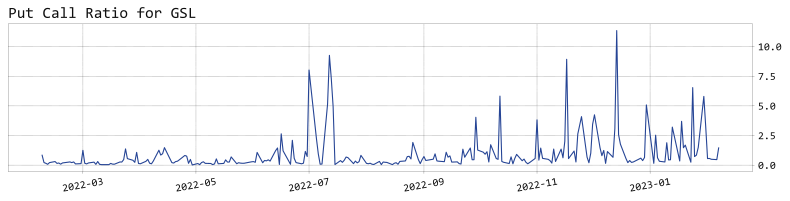

In [219]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [220]:
#expiry_dates = openbb.stocks.options.expirations(symbol)
#if (len(expiry_dates) > 0):
#    exp = expiry_dates[0]
#    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
#else:
#    option_chain = pd.DataFrame()


In [221]:
#if not option_chain.empty:
#    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
#    ax.plot(
#        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
#    )
#    ax.plot(
#        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
#    )
#    ax.legend()
#    fig.tight_layout()
#    f = io.BytesIO()
#    fig.savefig(f, format="svg")
#    vol_chart = f.getvalue().decode("utf-8")

In [222]:
#if not option_chain.empty:
#    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
#    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
#    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
#    ax.legend()
#    fig.tight_layout()
#    f = io.BytesIO()
#    fig.savefig(f, format="svg")
#    voi_chart = f.getvalue().decode("utf-8")

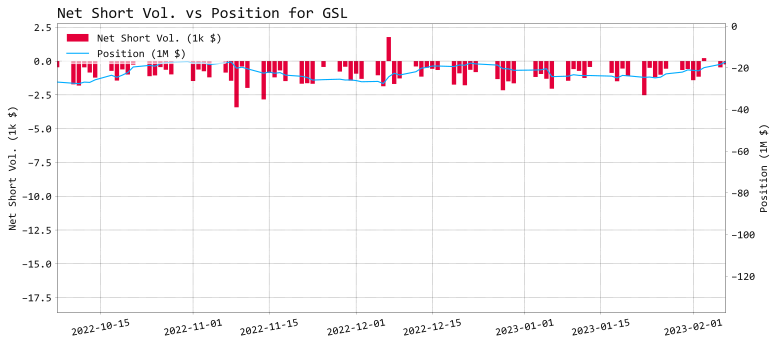

In [223]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

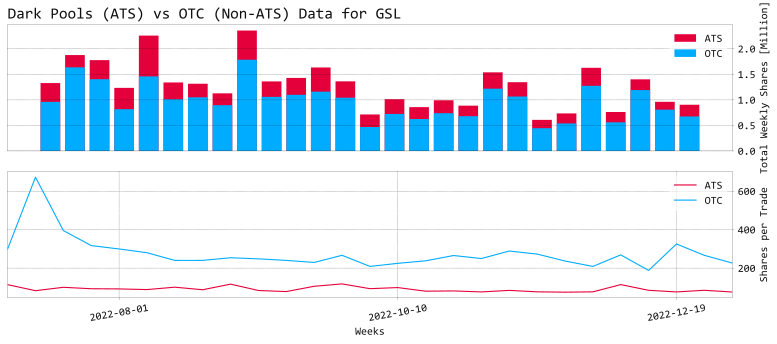

In [224]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

No congress trading data found

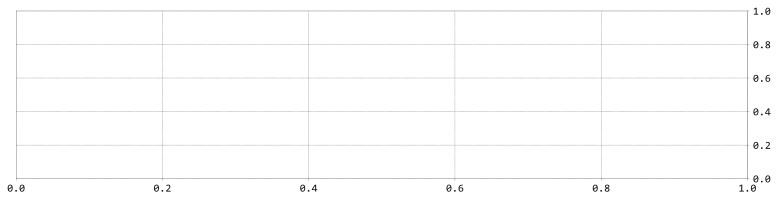

In [225]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

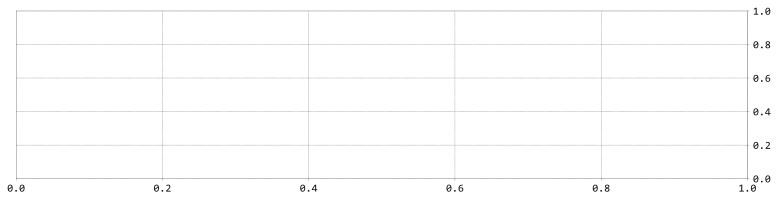

In [226]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

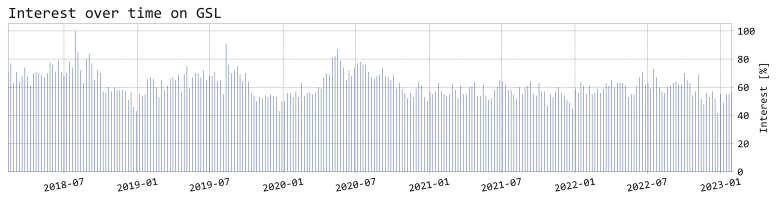

In [227]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

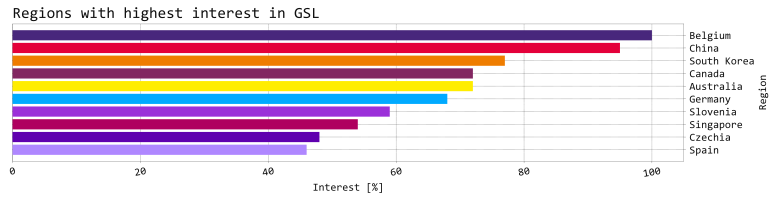

In [228]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")

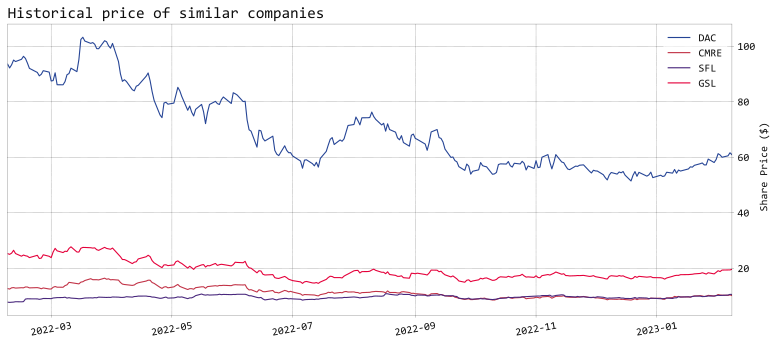

In [229]:

                    
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

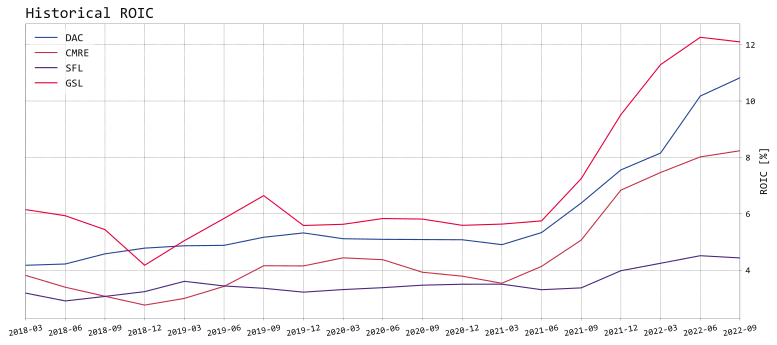

In [230]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"ROIC", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
roic_chart = f.getvalue().decode("utf-8")

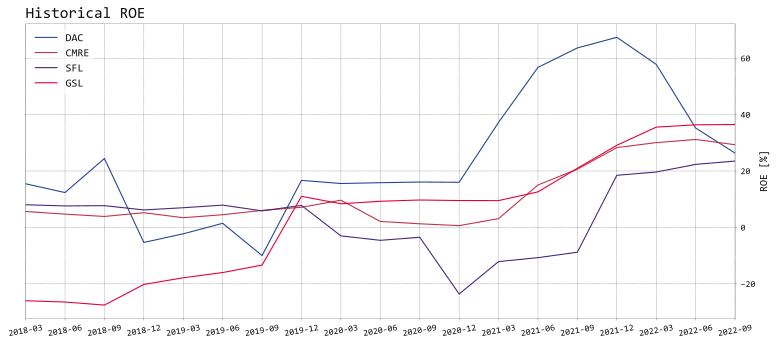

In [231]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"ROE", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
roe_chart = f.getvalue().decode("utf-8")

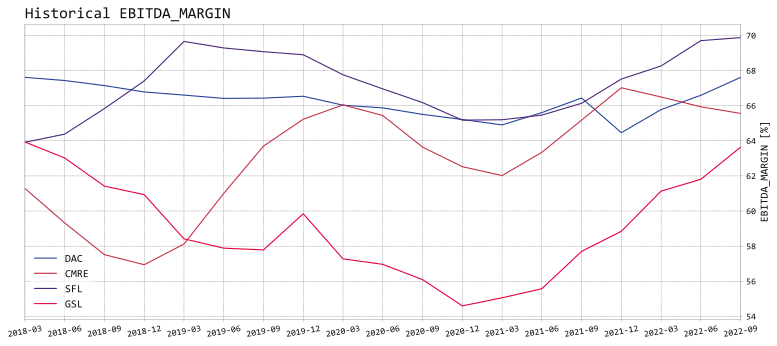

In [232]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"EBITDA_MARGIN", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ebitda_margin_chart = f.getvalue().decode("utf-8")

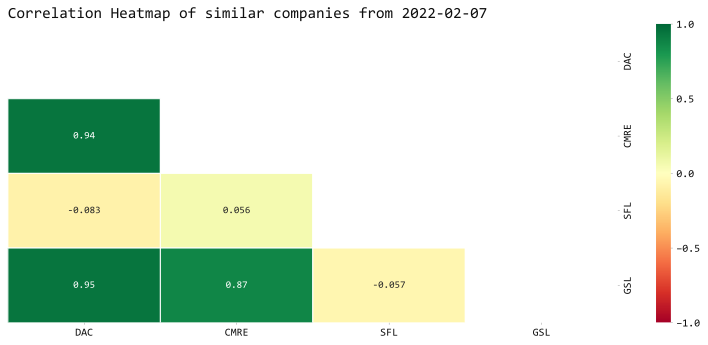

In [233]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

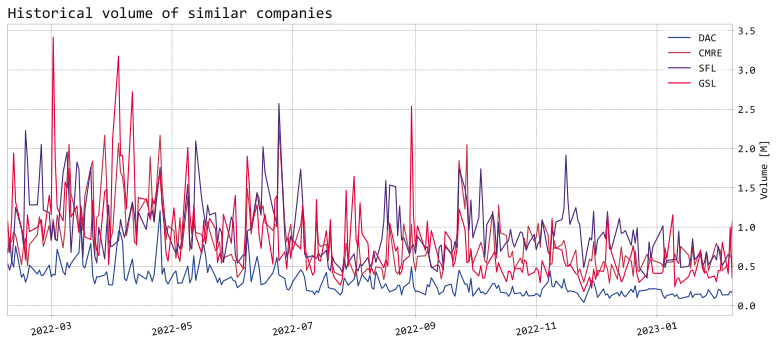

In [234]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

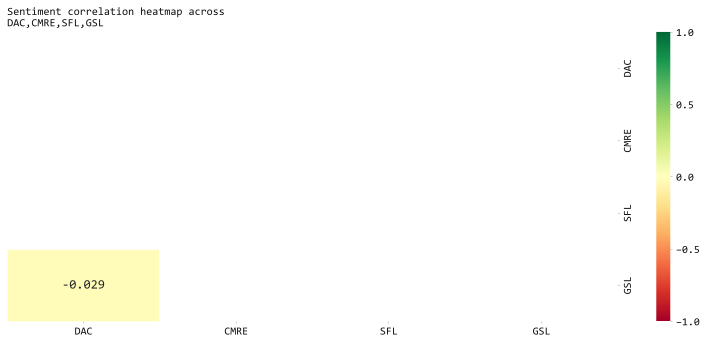

In [235]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [236]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])
valuation_comparison['Market Cap']=valuation_comparison['Market Cap'].apply(lambda x: "${0:.0f} M".format(x/1000000))

valuation_comparison = valuation_comparison.style.format({"EPS this Y": "${:,.2f}", "EPS next Y": "${:,.2f}", "EPS past 5Y": "${:,.2f}", 
                                                          "P/E": "{:,.2f}", "Fwd P/E":"{:,.2f}", "P/S": "{:,.2f}" , "P/B": "{:,.2f}" , 
                                                          "P/C":"{:,.2f}", "P/FCF": "{:,.2f}"} 
                                                        )
                                                      
#valuation_comparison['EPS this Y']=valuation_comparison['EPS this Y'].apply(lambda x: "${:,.2f}".format(x))

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,CMRE,$1320 M,2.62,3.03,1.17,0.64,2.05,13.30,$0.47,$-0.01,$0.33
1,DAC,$1260 M,2.22,2.41,1.32,0.52,nan,1.87,$6.93,$-0.26,$0.25
2,GSL,$695 M,2.60,2.24,1.10,0.78,5.79,2.69,$1.17,$0.09,$0.20
3,SFL,$1460 M,6.49,11.38,2.34,1.26,7.20,8.62,$1.57,$-0.38,$-0.05


In [237]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
financial_comparison['Dividend']=financial_comparison['Dividend'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROA']=financial_comparison['ROA'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROE']=financial_comparison['ROE'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROI']=financial_comparison['ROI'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Gross M']=financial_comparison['Gross M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Oper M']=financial_comparison['Oper M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Profit M']=financial_comparison['Profit M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison= financial_comparison.fillna("")
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,CMRE,4.4%,10.6%,26.4%,10.3%,2.0,1.9,1.17,1.35,72.2%,55.4%,43.3%
1,DAC,4.9%,15.3%,24.6%,13.6%,2.3,2.3,0.34,0.38,80.1%,62.9%,59.9%
2,GSL,7.7%,13.6%,34.5%,13.3%,0.8,0.8,0.86,1.07,70.8%,56.0%,44.3%
3,SFL,8.7%,6.5%,22.8%,7.2%,0.3,,1.40,2.34,71.7%,48.7%,37.5%


In [238]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])
ownership_comparison= ownership_comparison.fillna("")
ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,CMRE,121430000.0,51940000.0,0.779,0.0,0.226,-0.0426,0.0387,3.47
1,DAC,20300000.0,10820000.0,0.587,0.0,0.214,-0.1932,0.0569,3.57
2,GSL,36650000.0,34050000.0,0.790,0.0,0.476,-0.1075,0.0896,5.99
3,SFL,126790000.0,116510000.0,0.434,0.0,0.346,-0.0471,0.0147,2.10


In [239]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])
performance_comparison['Perf Week']=performance_comparison['Perf Week'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Month']=performance_comparison['Perf Month'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Quart']=performance_comparison['Perf Quart'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Half']=performance_comparison['Perf Half'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Year']=performance_comparison['Perf Year'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf YTD']=performance_comparison['Perf YTD'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison= performance_comparison.fillna("")
performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,CMRE,-3.7%,6.5%,1.9%,-12.6%,-23.1%,9.6%,0.0340,0.0328,1.7
1,DAC,-0.4%,12.4%,-1.2%,-19.8%,-37.3%,15.9%,0.0349,0.0314,1.7
2,GSL,2.8%,15.0%,8.4%,-0.5%,-27.4%,18.1%,0.0415,0.0305,1.5
3,SFL,3.1%,15.9%,1.3%,3.7%,24.3%,14.9%,0.0182,0.0224,1.8


In [240]:
df_historical_metrics = openbb.stocks.fa.metrics(symbol)
df_historical_metrics

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Revenue per share,11.039,15.720,22.016,21.115,22.966
Net income per share,4.703,2.310,3.359,-7.710,-10.728
Operating cash flow per share,7.239,5.805,7.874,6.417,8.352
Free cash flow per share,-6.223,3.223,-0.482,4.493,7.646
Cash per share,2.062,4.489,11.638,11.029,10.583
Book value per share,19.541,25.832,34.268,42.521,36.345
Tangible book value per share,19.541,25.832,34.144,41.795,36.344
Shareholders equity per share,19.541,25.832,34.268,42.521,36.345
Interest debt per share,31.255,46.402,81.950,124.447,66.145


In [241]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [242]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

No quarterly government contracts found

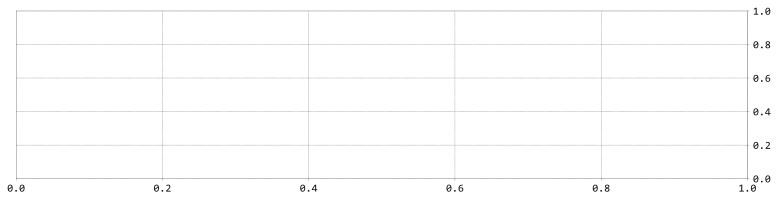

In [243]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [244]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

No corporate lobbying found

""


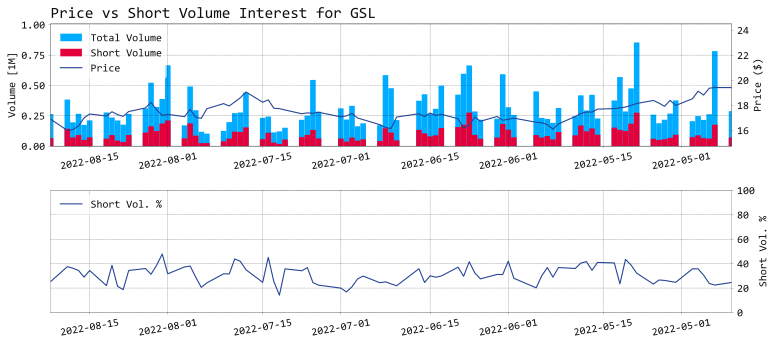

In [245]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

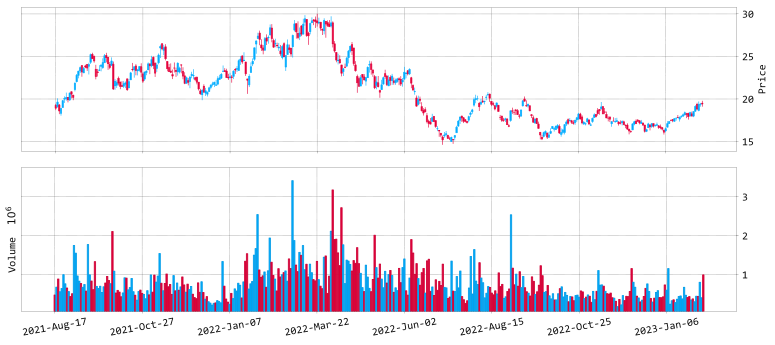

In [246]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

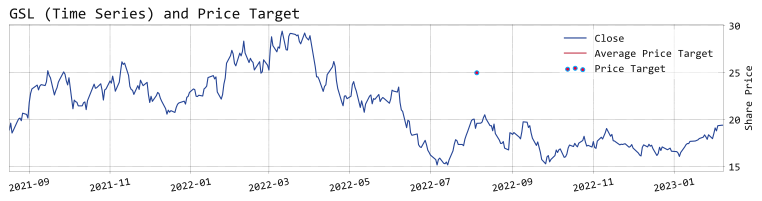

In [247]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [248]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

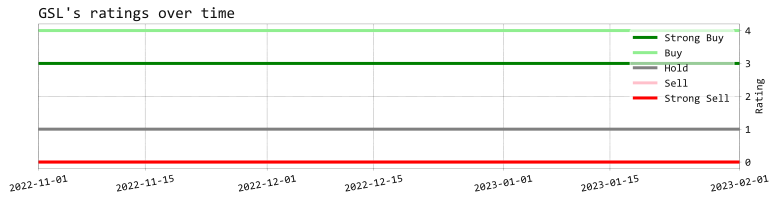

In [249]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

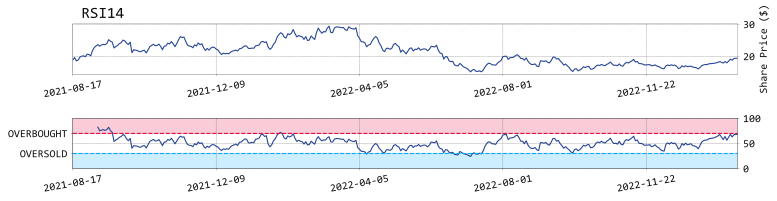

In [250]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [251]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

67.91

In [252]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [253]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

No insider information found for GSL.

empty


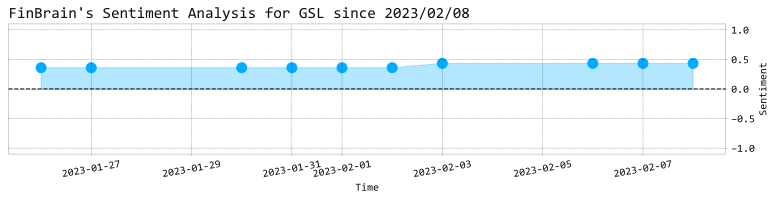

In [254]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [255]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [256]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 4937</br>\nLast 3 sentiment messages:</br>Bullish 100.0%</br>Bearish 0.0%'

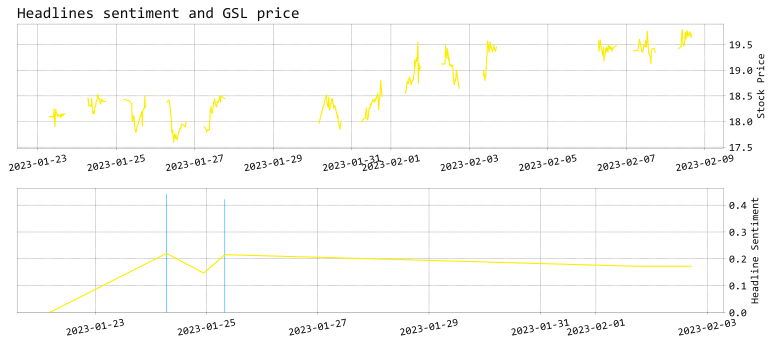

In [257]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [258]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for GSL with starting period 2019-08-28.

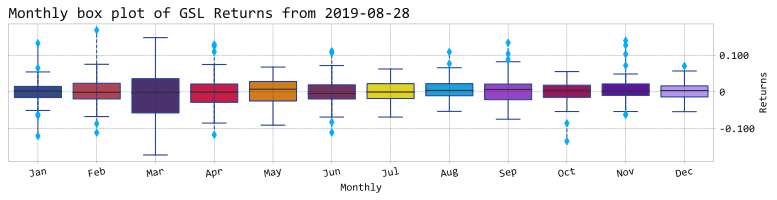

In [259]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

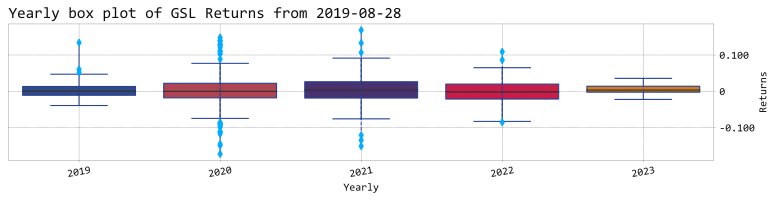

In [260]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [261]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for GSL

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

In [262]:
hist_ratios = openbb.stocks.fa.ratios(symbol)
hist_ratios

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Current ratio,0.586,0.879,1.249,1.036,1.357
Quick ratio,0.332,0.755,1.113,0.888,1.328
Cash ratio,0.275,0.720,1.065,0.859,1.285
Days of sales outstanding,5.547,5.168,8.681,6.375,5.652
Days of inventory outstanding,20.319,14.322,14.512,24.399,3.326
Operating cycle,25.865,19.490,23.193,30.774,8.978
Days of payables outstanding,14.077,21.370,20.981,37.764,6.660
Cash conversion cycle,11.788,-1.880,2.212,-6.989,2.318
Gross profit margin,0.491,0.431,0.461,0.451,0.488


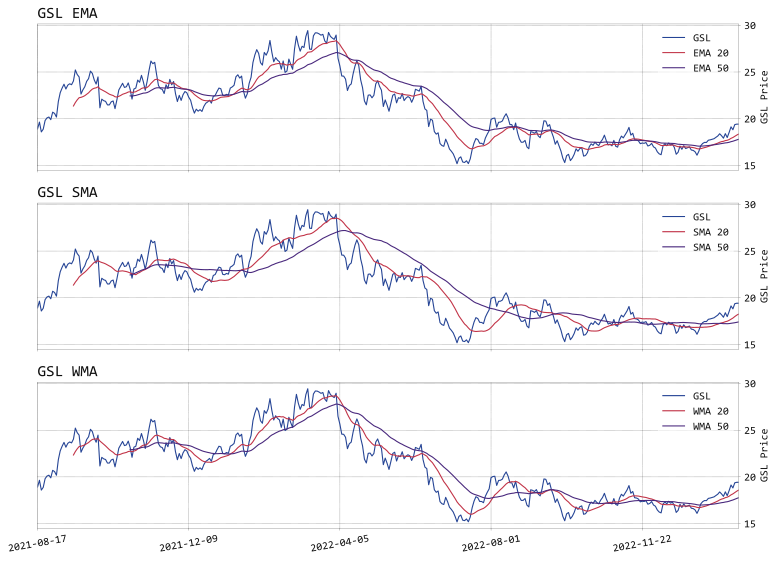

In [263]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

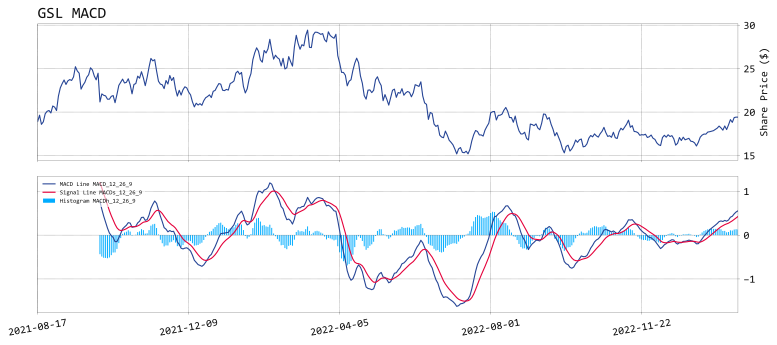

In [264]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

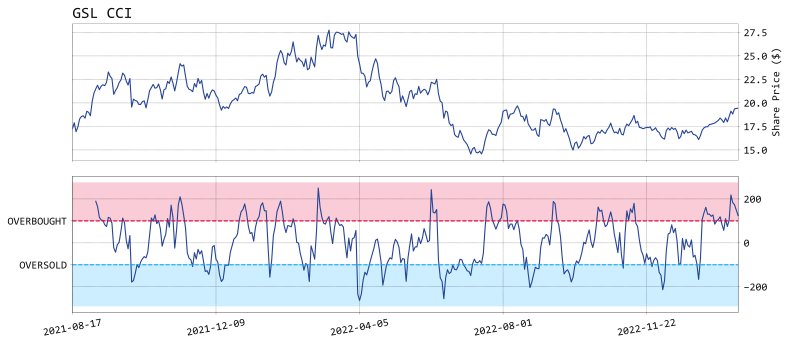

In [265]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

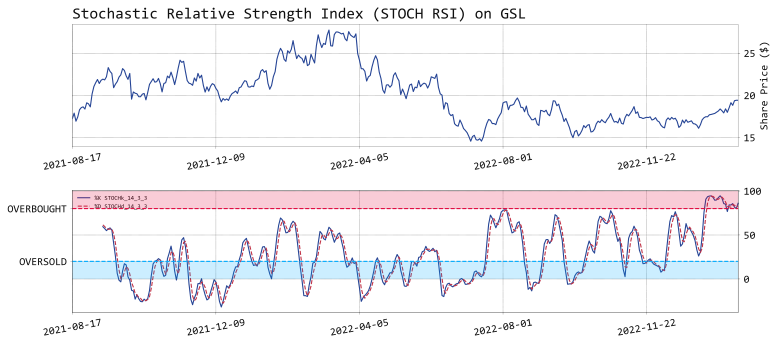

In [266]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

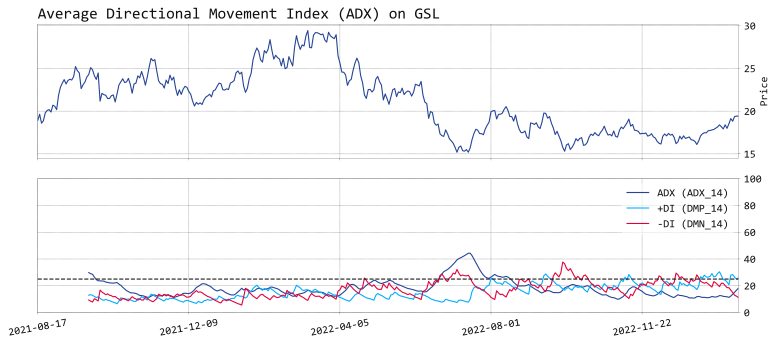

In [267]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

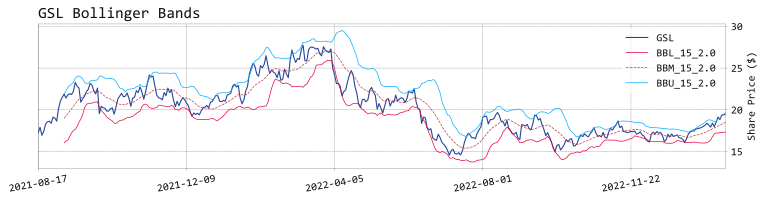

In [268]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

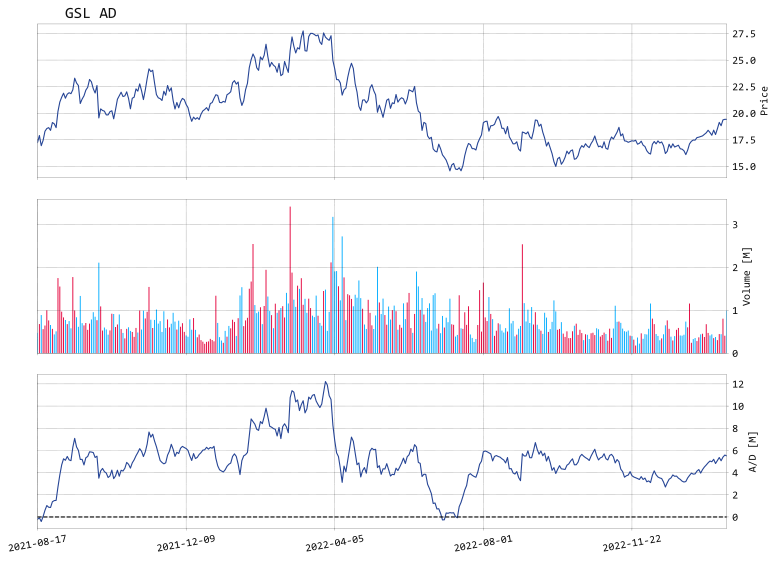

In [269]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [270]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
                {{
                "width": "1085",
                "height": "500",
                "colorTheme": "light",
                "isTransparent": false,
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

if (investor_report_url): 
    htmlcode += widgets.row([widgets.h(3, "Investor Presentation for " + symbol)])
    htmlcode += f"""
        <div class="hcontainer">
            <div class="item">
                <iframe src="{investor_report_url}" width="1085" height="700"></iframe>
            </div>
        </div>
            """

            
body += widgets.add_tab("Summary", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
        <div class="tradingview-widget-container">
        <div id="tradingview_fceac"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
        <script type="text/javascript">
        new TradingView.MediumWidget(
            {{
            "symbols": [
                [
                "{long_name}",
                "{exchange}:{symbol}|1D"
                ]
            ],
            "chartOnly": false,
            "width": "1085",
            "height": "700",
            "locale": "en",
            "colorTheme": "light",
            "autosize": false,
            "showVolume": false,
            "hideDateRanges": false,
            "hideMarketStatus": false,
            "scalePosition": "right",
            "scaleMode": "Normal",
            "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
            "fontSize": "10",
            "noTimeScale": false,
            "valuesTracking": "1",
            "chartType": "line",
            "container_id": "tradingview_fceac"
            }}
        );
        </script>
        </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
<div class="hcontainer">
    <div class="item">
        <div class="tweet-list">
            {% for tweet in tweets %}
            <div class="tweet">
                <div class="tweet-header">
                    <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                    <h3>{{ tweet.user.name }}</h3>                   
                </div>       
                <div class="tweet-body">
                    <p>{{ tweet.full_text }}</p>
                </div>   
                {% if tweet.entities.media %}
                    <div class="tweet-media">
                    {% for media in tweet.entities.media %}
                        <img src="{{ media.media_url_https }}" alt="Tweet media">
                    {% endfor %}
                    </div>
                {% endif %}
                <div class="tweet-footer">
                    {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                    <p>{{ date }}</p>
                    <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
                </div>
            </div>
            {% endfor %}
        </div>
    </div>
</div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

if(morningstar_report_url):
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis " + symbol)])
    htmlcode += f"""
            <div class="hcontainer">
                <div class="item">
                <iframe src="{morningstar_report_url}" width="1085" height="700" allow="autoplay"></iframe>
                </div>
            </div>
                """
else:
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis not available ")])

htmlcode += widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.head(15).to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
                {{
                "colorTheme": "light",
                "isTransparent": false,
                "largeChartUrl": "",
                "displayMode": "regular",
                "width": "1085",
                "height": "800",
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Shares outstanding ") + shares_outstanding_chart]
    )
except:
    pass

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Ratios") + hist_ratios.to_html(escape=False)])

htmlcode += widgets.row([widgets.h(3, "Metrics") + df_historical_metrics.to_html(escape=False)])

body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
#if not option_chain.empty:
#    htmlcode += widgets.row(
#        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
#    )
#    htmlcode += widgets.row(
#        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
#    )
#try:
#    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
#except:
#    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

htmlcode = widgets.row(
    [
        widgets.h(3, f"Return on invested capital for companies similar to {symbol}")
        + roic_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Return on equity for companies similar to {symbol}")
        + roe_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"EBITDA margin for companies similar to {symbol}")
        + ebitda_margin_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)

try:
    htmlcode += widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
                {{
                "interval": "1W",
                "width": "1085",
                "isTransparent": false,
                "height": "700",
                "symbol": "{exchange}:{symbol}",
                "showIntervalTabs": true,
                "locale": "en",
                "colorTheme": "light"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)